In [26]:
from util_nn import *

import matplotlib 
import matplotlib.pyplot as plt
#%matplotlib inline
import IPython.display as ipd
import copy
import util_midi
import mir_eval
from util_midi import *
%matplotlib inline

def rmsq(X):
    return np.sqrt((X**2).mean())
def mroll2chroma(mroll,norm = 1):
#     if chroma:
    mroll = mroll[:,:120]
    SP = list(mroll.shape)
#         SP[1] = 12; SP.append(-1)
#         mroll = np.reshape(mroll,SP).sum(axis = 2)
    SP[1] = -1; SP.append(12)
    cmroll = np.reshape(mroll,SP).sum(axis = 1)
#     cmroll = np.clip(cmroll,0,1)
    #     cmroll = 
    if norm:
#         SUM = cmroll.sum(axis = 1,keepdims =1 )
#         SUM[SUM==0]=1
#         cmroll = cmroll / SUM.astype(float)
        cmroll = np.clip(cmroll,0,1)
    return cmroll 
#     print mroll.shape

    
def midi_roll_play(mroll,chroma = False):
    if mroll.shape[-1]==12:
        freqs = mir_eval.transcription.util.midi_to_hz(np.arange(60,72))
    else:
        freqs = mir_eval.transcription.util.midi_to_hz(np.arange(0,128))
    Xs_exp = mir_eval.sonify.time_frequency( mroll.T,freqs,times = 1./20*np.arange(len(mroll)),fs = 16000)
#     Xs_exp = np.hstack([Xs_exp,[0]*(len(cpXs)-len(Xs_exp))])
    return Xs_exp/np.sqrt((Xs_exp**2).mean())


def compare(log = 1, mode = 'test',chroma = False):
    best_agent = copy.copy(agent)
    best_agent.load()
    plt.figure()

    if mode == 'test':
        pXs = data[0]["X"][:100]
        pYs_exp = data[0]["Y"][:100]
    else:
        pXs = Xs[:100]
        pYs_exp = Ys[:100]
#     assert not (pXs[0] - Xs[0]).any()
#     pXs = Xs[:500]
#     pYs_exp = Ys[:500]
    pYs_act = best_agent.model.predict_on_batch(pXs) 
    pYs_act += 1E-5
#     compare(log = 1)
    if chroma:
        pYs_exp = mroll2chroma(pYs_exp)
        pYs_act = mroll2chroma(pYs_act)
    plt.pcolormesh(pYs_exp.T,alpha = 0.75)
#     plt.gca().set_xlim(0,200)
    if chroma:
        YLIM = [0,12]
    else:
        YLIM = [40,90]
    plt.gca().set_ylim(YLIM)

#     plt.figure()
    Z1 = pYs_act.T
    if log:
        plt.pcolormesh(Z1,
                       alpha = 0.5,
                  norm=matplotlib.colors.LogNorm(vmin=Z1.min(), vmax=Z1.max())
                  )
    else:
        plt.pcolormesh(Z1)
    plt.gca().set_ylim(YLIM)
    
    ipd.display(ipd.Audio(midi_roll_play(pYs_act),rate = 16000))
    ipd.display(ipd.Audio(midi_roll_play(pYs_exp),rate = 16000))

    
# ali = 'test'
# alias = 't4'
def pretrain(agent = None, batchsize = 30000,nepc = 10):
    IniEPOCH=0
    if agent is None:
        agent = PGAgent(16000/20, 128,model = make_model())

    # data = load_data()
    # Xs,Ys = make_buffer(data[1:])
    if batchsize== -1:
        batchsize = len(Xs)
    idx = np.random.choice(len(Xs),batchsize,replace=0)
    subXs = Xs[idx]
    subYs = Ys[idx]

    opt_par = {'lr': 0.01, 'momentum': 0.75,'decay':0.000}
#     opt_par.update({'loss':LOSS})
    opt = keras.optimizers.sgd(**opt_par)
    try:
    #     agent.load()
        pass
    except Exception as e:
        print e
    # opt_par = {}
    # opt = keras.optimizers.Adam(**opt_par)
    # agent.name = "adam_%s"%opt_par_flat

    opt_par_flat = '-'.join(['_'.join(str(y) for y in x) for x in opt_par.items()]).replace('.','Dot')
    agent.name = "sgd_%s_%s"% (alias,flatten_param(opt_par))



    agent.model.compile(loss=LOSS, optimizer=opt
                         ,metrics=['accuracy'])

#     nepc = 10
    r = agent.model.fit(subXs, subYs, epochs= IniEPOCH + nepc, initial_epoch=IniEPOCH, batch_size=512, validation_split=0.2,shuffle = 1, verbose = 1,
                         callbacks=default_callbacks(agent))
    IniEPOCH += nepc
    plot_model_loss(r)
    return agent,r
# agent = pretrain()
# compare(log = 1, mode = 'test',chroma = 1)
# compare(log = 1, mode = 'test',chroma = 0)

# pXs = data[0]["X"][:100]
# pYs_exp = data[0]["Y"][:100]
# ipd.display(ipd.Audio(midi_roll_play(pYs_exp,chroma = 1),rate = 16000))

import sys
# class ClearlineCallback(keras.callbacks.Callback):
#     def on_epoch_end(self, epoch, logs={}):
#         sys.stdout.write("\033[F")
#         sys.stdout.write("\033[F")
#         print "\r\r"
class NewlineCallback(keras.callbacks.Callback):
    def on_epoch_begin(self, epoch, logs={}):
        print
    def on_epoch_end(self, epoch, logs={}):
        print
        pass
#         print "\n"
import keras


def default_callbacks(self):
    ck_all = self.callback_checkpoint(0)
    ck_best = self.callback_checkpoint(1)
    callbacks = [
#         ClearlineCallback(),
#         keras.callbacks.ProgbarLogger(),
                 NewlineCallback(),
                 ck_all,
                 ck_best,
#                  NewlineCallback()
                ]
    return callbacks

# def abs_KL_div(y_true, y_pred):
#     y_true = K.clip(y_true, K.epsilon(), 1)
#     y_pred = K.clip(y_pred, K.epsilon(), 1)
#     return K.sum(y_true * K.abs(K.log(y_true / y_pred)), axis=-1)

In [31]:
# LOSS = 'kullback_leibler_divergence'
# LOSS = 'mean_absolute_percentage_error'
# LOSS = 'mean_absolute_error'
# LOSS = 'mean_squared_error'
# LOSS = 'hinge'
# LOSS = 'categorical_crossentropy'
# LOSS = 'mean_per'
# LOSS = 'binary_crossentropy'
alias = 't9'
# ACT_FUNC = "selu"
ACT_FUNC = "relu"
# tf.device('/cpu:0')
# LOSS = 'sparse_categorical_crossentropy'
# LOSS = 'binary_crossentropy'
from keras.models import Model


Ns = [2,3,4,5,6][::-1]
Ss = [1,2,2,3,4][::-1]
LOSS = abs_KL_div


def make_model(self = None):
    
    model = Sequential()
#         model = Sequential_wrapper()
#         model.add(Reshape((80, 80, 1), input_shape=(self.state_size,)))
    
#     model.add(Reshape((self.state_size,1), input_shape=(self.state_size,)))
    input_size = 800; output_size = 128
    model.add(Reshape((input_size,1,1), input_shape=(input_size,)))

#     S = 85;niter = 1
    S = 9;niter = 2
#     S = 4;niter = 3    
    niter = 4
    n = S
    nextlayer = lambda x:(    x//n - 1)
    
    N0 = 64
    S2 = 30
    N2 = 10
    Lx = 800
    
#         if i == 0:

#     #         N = 1 if i==0 else N0
#             N = N0
#             if i==0:
#                 N2_curr = 1
#             else:
#                 N2_curr = N2
    N2_curr = 1
    N = 10
#     model.add(Conv2D( N, ( int(1.5*S),   N2_curr), strides=(S, N2_curr),
#     #                          subsample=(1, 1), 
#     #                          border_mode='same',
#                      border_mode='valid',
#                             activation=ACT_FUNC, init='he_uniform'))
#     model. add(Flatten())
#             model.add( Permute( (1,3,2,) ) )
#             Lx = nextlayer(Lx)

            
#             model.add(Conv2D( N, (1, N,), strides=(1,N),
#                              border_mode='valid',
#                                     activation=ACT_FUNC, init='he_uniform'))
#             model.add( Permute( (1,3,2,) ) )
#         else:
#             model.add(Conv2D( 16, ( int(1.5*S),   int(1.5 * S2)), strides=(S, S2),
#             #                          subsample=(1, 1), 
#             #                          border_mode='same',
#                              border_mode='valid',
#                                     activation=ACT_FUNC, init='he_uniform'))
#             N = 16
#             model.add( Permute( (1,3,2,) ) )
#             model.add(Conv2D( N, (1, N,), strides=(1,N),
#                              border_mode='valid',
#                                     activation=ACT_FUNC, init='he_uniform'))
#             model.add( Permute( (1,3,2,) ) )
#             pass
#     Ns = [128,64,32,64,128]
#     Ns = [128,128,100,64,64,64,100,128]
    def conv_dense(model,N,S, reshape = 1):
        model.add(Conv2D( N, ( S*2, 1), strides=(S, 1),
    #             #                          subsample=(1, 1), 
    #             #                          border_mode='same',
                                 border_mode='valid',
                                        activation=ACT_FUNC, init='he_uniform'))
        model.add(Dense(N,activation=ACT_FUNC,
#                              kernel_regularizer=keras.regularizers.l2(0.1),
#                             activity_regularizer=keras.regularizers.l1(0.01)
               )
         )
        
        
#     from keras.layers import Input, Embedding, LSTM, Dense
#     from keras.models import Model

    # Headline input: meant to receive sequences of 100 integers, between 1 and 10000.
    # Note that we can name any layer by passing it a "name" argument.
    main_input = Input(shape=(800,), 
#                        dtype='int32', name='main_input'
                      )
    curr = Reshape((input_size,1,1), input_shape=(input_size,))(main_input)
    # This embedding layer will encode the input sequence
    # into a sequence of dense 512-dimensional vectors.
#     x = Embedding(output_dim=512, input_dim=10000, input_length=100)(main_input)

    # A LSTM will transform the vector sequence into a single vector,
    # containing information about the entire sequence
    S = 16
    N = 16
    niter = 1
    rNS = 0.5

    def conv_layer(curr,S,rNS=0.5):
#         S = 8
#         N = int(S/rNS)
        N = 16
#         N = S // rNS
        conv0 = Conv2D( N, ( S*2, 1),
                       strides=(S, 1),
#                                      border_mode='valid',
                                     border_mode='same',
                                            activation=ACT_FUNC, init='he_uniform')(curr)
        if SC == 1:
            ### A
            conv0 = Reshape((-1,25,N))(conv0)
            return conv0
        elif SC == 2:
            ### B
            conv0 = Reshape((25,-1,N))(conv0)
            return conv0

    
#     for S in 2**np.arange(3,6):
    N = 5
    S = 5
#     Ns = [3,4,5,6]
#     Ss = [3,4,5,6]
#     Ns = [2,2,6,6,6][::-1]
#     Ss = [1,1,3,5,6][::-1]
#     Ns = [3,4,5,6][::-1]
#     Ss = [3,4,5,6][::-1]
#     Ns = [1,4,5,6][::-1]
#     Ss = [3,4,5,6][::-1]
#     Ns = [3,7,9,12][::-1]
#     Ns = [5,7,8,9][::-1]
#     Ss = [2,3,3,3][::-1]
#     Ns = [6,6,6][::-1]
#     Ss = [3,3,3][::-1]
#     Ns = [2,3,4,5][::-1]
#     Ss = [1,2,3,4][::-1]
#     Ns = [5,7,8,9][::-1]
#     Ns = [2,3,4,5][::-1]

#     Ss = [3,4,4,4][::-1]
#     Ns = [2,6,8,10][::-1]
#     Ss = [3,4,5,6][::-1]
#     Ss = [2,3,4,5][::-1]
#     Ns = [12,12,2,2]
#     Ss = [1,1,16,16]
#     imax = 4
    imax = len(Ns)
    for i in range(imax):
#     for i in range(int(np.log(800)/np.log(S))-1):
        N = Ns[i];S = Ss[i]
        curr = Conv2D( N, ( S*4, 1),
               strides=(S, 1),
                                     border_mode='valid',
#                              border_mode='same',
                                    activation=ACT_FUNC, init='he_uniform')(curr)
#           print curr.get_shape()[1]
#         curr = Reshape((int(curr.get_shape()[1]),-1,1))(curr)
        curr = Reshape((int(curr.get_shape()[1]),1,-1))(curr)
#         curr = Dense(int(curr.get_shape()[-1]))(curr)
        if i+1==imax:
#             curr = Dense(12)(curr)
            pass
        curr = Permute((1,3,2))(curr)
#         conv=conv_layer(curr,(800//S + 800//(S+1))//2)
#         conv=conv_layer(curr,S)
#         clayer.append(
#     curr = Flatten()(curr)
    concat = curr
#     main_output = Dense(128,activation='softmax')(Flatten()(concat))
#     main_output = Dense(12,activation='softmax')(Flatten()(concat))
#     main_output = Dense(12,activation='sigmoid')(Flatten()(concat))
#     main_output = Dense(12,activation='linear')(Flatten()(concat))
    main_output = Dense(12,activation='softmax')(Flatten()(concat))
    model = Model(inputs=[main_input], outputs=[main_output])

    opt = Adam()
    model.compile(loss=LOSS, optimizer=opt
                 ,metrics=['accuracy'])
    return model
# model.add(Dense(100, activation='relu'))
# make_model()

agent = PGAgent(16000/20, 128,model = make_model())
# agent.load()
agent.summary()
IniEPOCH = 0

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_17 (InputLayer)        (None, 800)               0         
_________________________________________________________________
reshape_114 (Reshape)        (None, 800, 1, 1)         0         
_________________________________________________________________
conv2d_82 (Conv2D)           (None, 197, 1, 6)         102       
_________________________________________________________________
reshape_115 (Reshape)        (None, 197, 1, 6)         0         
_________________________________________________________________
permute_81 (Permute)         (None, 197, 6, 1)         0         
_________________________________________________________________
conv2d_83 (Conv2D)           (None, 62, 6, 5)          65        
_________________________________________________________________
reshape_116 (Reshape)        (None, 62, 1, 30)         0         
__________

/home/shouldsee/.local/lib/python2.7/site-packages/ipykernel_launcher.py:173: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(6, (16, 1), kernel_initializer="he_uniform", activation="relu", padding="valid", strides=(4, 1))`
/home/shouldsee/.local/lib/python2.7/site-packages/ipykernel_launcher.py:173: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(5, (12, 1), kernel_initializer="he_uniform", activation="relu", padding="valid", strides=(3, 1))`
/home/shouldsee/.local/lib/python2.7/site-packages/ipykernel_launcher.py:173: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(4, (8, 1), kernel_initializer="he_uniform", activation="relu", padding="valid", strides=(2, 1))`
/home/shouldsee/.local/lib/python2.7/site-packages/ipykernel_launcher.py:173: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(3, (8, 1), kernel_initializer="he_uniform", activation="relu", padding="valid", strides=(2, 1))`
/home/shouldsee/.local/lib/pyt

In [74]:
# print np.log(4,[800])
# np.log

In [10]:
'''

Ns = [4,6,7,8][::-1]
Ss = [2,3,3,3][::-1]


Epoch 10/10
23552/24000 [============================>.] - ETA: 0s - loss: 12.5991 - acc: 0.3321
Epoch 00009: saving model to Models/tst-best_only.hdf5
Epoch 00009: val_acc did not improve
24000/24000 [==============================] - 9s - loss: 12.5981 - acc: 0.3313 - val_loss: 12.9677 - val_acc: 0.2910


[4,4,4,4]
[2,2,2,2]
Epoch 10/10
23552/24000 [============================>.] - ETA: 0s - loss: 12.9018 - acc: 0.3094
Epoch 00009: saving model to Models/tst-best_only.hdf5
Epoch 00009: val_acc did not improve
24000/24000 [==============================] - 12s - loss: 12.9003 - acc: 0.3092 - val_loss: 13.4730 - val_acc: 0.2400



Ns = [4,6,7,8][::-1]
Ss = [2,3,3,3][::-1]
###Key: downsample at bottom, uniform sample at top

Epoch 10/10
23552/24000 [============================>.] - ETA: 0s - loss: 12.5989 - acc: 0.3325
Epoch 00009: saving model to Models/tst-best_only.hdf5
Epoch 00009: val_acc did not improve
24000/24000 [==============================] - 9s - loss: 12.5979 - acc: 0.3318 - val_loss: 12.9672 - val_acc: 0.2923




Ns = [2,3,4,5][::-1]
Ss = [1,2,3,4][::-1]
LOSS = abs_KL
Epoch 1/2
100352/101008 [============================>.] - ETA: 0s - loss: 3.1951 - acc: 0.3948
Epoch 00001: saving model to Models/tst-best_only.hdf5
Epoch 00001: val_acc improved from -inf to 0.38629, saving model to Models/sgd_t9_lr_0Dot01-momentum_0Dot75-decay_0Dot0-01-0.39.hdf5
101008/101008 [==============================] - 6s 57us/step - loss: 3.1940 - acc: 0.3948 - val_loss: 3.1270 - val_acc: 0.3863



Train on 101008 samples, validate on 25253 samples

Epoch 1/2
100352/101008 [============================>.] - ETA: 0s - loss: 13.2737 - acc: 0.4374 ETA: 0s - loss: 13.3008 - acc: 
Epoch 00001: saving model to Models/tst-best_only.hdf5
Epoch 00001: val_acc improved from -inf to 0.45947, saving model to Models/sgd_t9_lr_0Dot01-momentum_0Dot75-decay_0Dot0-01-0.46.hdf5
101008/101008 [==============================] - 10s 103us/step - loss: 13.2644 - acc: 0.4375 - val_loss: 12.2623 - val_acc: 0.4595
'''

'\n\nNs = [4,6,7,8][::-1]\nSs = [2,3,3,3][::-1]\n\n\nEpoch 10/10\n23552/24000 [============================>.] - ETA: 0s - loss: 12.5991 - acc: 0.3321\nEpoch 00009: saving model to Models/tst-best_only.hdf5\nEpoch 00009: val_acc did not improve\n24000/24000 [==============================] - 9s - loss: 12.5981 - acc: 0.3313 - val_loss: 12.9677 - val_acc: 0.2910\n\n\n[4,4,4,4]\n[2,2,2,2]\nEpoch 10/10\n23552/24000 [============================>.] - ETA: 0s - loss: 12.9018 - acc: 0.3094\nEpoch 00009: saving model to Models/tst-best_only.hdf5\nEpoch 00009: val_acc did not improve\n24000/24000 [==============================] - 12s - loss: 12.9003 - acc: 0.3092 - val_loss: 13.4730 - val_acc: 0.2400\n\n\n\nNs = [4,6,7,8][::-1]\nSs = [2,3,3,3][::-1]\n###Key: downsample at bottom, uniform sample at top\n\nEpoch 10/10\n23552/24000 [============================>.] - ETA: 0s - loss: 12.5989 - acc: 0.3325\nEpoch 00009: saving model to Models/tst-best_only.hdf5\nEpoch 00009: val_acc did not improve

In [29]:
data = load_data('sample/MIDI/midiworld/')
Xs,Ys= make_buffer(data[1:])
Ys = mroll2chroma(Ys,norm = 1)

/home/shouldsee/.local/lib/python2.7/site-packages/ipykernel_launcher.py:173: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(6, (16, 1), kernel_initializer="he_uniform", activation="relu", padding="valid", strides=(4, 1))`
/home/shouldsee/.local/lib/python2.7/site-packages/ipykernel_launcher.py:173: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(5, (12, 1), kernel_initializer="he_uniform", activation="relu", padding="valid", strides=(3, 1))`
/home/shouldsee/.local/lib/python2.7/site-packages/ipykernel_launcher.py:173: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(4, (8, 1), kernel_initializer="he_uniform", activation="relu", padding="valid", strides=(2, 1))`
/home/shouldsee/.local/lib/python2.7/site-packages/ipykernel_launcher.py:173: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(3, (8, 1), kernel_initializer="he_uniform", activation="relu", padding="valid", strides=(2, 1))`
/home/shouldsee/.local/lib/pyt

Train on 24000 samples, validate on 6000 samples

Epoch 1/5
23552/24000 [============================>.] - ETA: 0s - loss: 5.5863 - acc: 0.0987- ETA: 3s - loss: 5.5890 - acc
Epoch 00001: saving model to Models/tst-best_only.hdf5
Epoch 00001: val_acc improved from -inf to 0.16700, saving model to Models/sgd_t9_lr_0Dot01-momentum_0Dot75-decay_0Dot0-01-0.17.hdf5
24000/24000 [==============================] - 13s 548us/step - loss: 5.5873 - acc: 0.0998 - val_loss: 5.5111 - val_acc: 0.1670

Epoch 2/5
23040/24000 [===========================>..] - ETA: 0s - loss: 5.5146 - acc: 0.1271
Epoch 00002: saving model to Models/tst-best_only.hdf5
Epoch 00002: val_acc did not improve
24000/24000 [==============================] - 3s 105us/step - loss: 5.5098 - acc: 0.1268 - val_loss: 5.5051 - val_acc: 0.0793

Epoch 3/5
23552/24000 [============================>.] - ETA: 0s - loss: 5.5027 - acc: 0.1256
Epoch 00003: saving model to Models/tst-best_only.hdf5
Epoch 00003: val_acc did not improve
24000/240

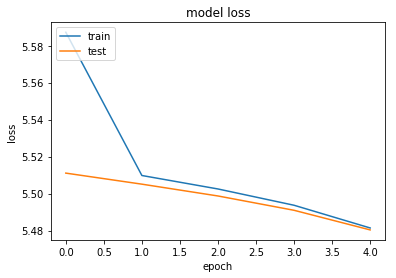

In [42]:
import numpy as np
np.random.seed(0)
# LOSS = 'categorical_crossentropy'
# LOSS = 'categorical_crossentropy'
# LOSS = abs_KL_div

LOSS = 'kullback_leibler_divergence'
# LOSS = 'binary_crossentropy'
agent,r = pretrain(nepc = 5)

In [35]:
# print( len(Xs))a
print agent.load('Models/sgd_t9_lr_0Dot01-momentum_0Dot75-decay_0Dot0-01-0.43.hdf5')

None


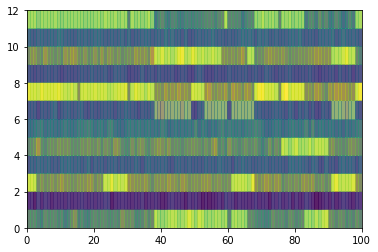

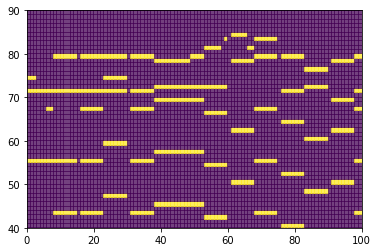

Train on 100980 samples, validate on 25245 samples

Epoch 1/2
100864/100980 [============================>.] - ETA: 0s - loss: 13.6569 - acc: 0.2749
Epoch 00001: saving model to Models/tst-best_only.hdf5
Epoch 00001: val_acc improved from -inf to 0.29028, saving model to Models/sgd_t9_lr_0Dot01-momentum_0Dot75-decay_0Dot0-01-0.29.hdf5
100980/100980 [==============================] - 20s 201us/step - loss: 13.6538 - acc: 0.2749 - val_loss: 11.4255 - val_acc: 0.2903

Epoch 2/2
100352/100980 [============================>.] - ETA: 0s - loss: 10.5996 - acc: 0.3338
Epoch 00002: saving model to Models/tst-best_only.hdf5
Epoch 00002: val_acc improved from 0.29028 to 0.32256, saving model to Models/sgd_t9_lr_0Dot01-momentum_0Dot75-decay_0Dot0-02-0.32.hdf5
100980/100980 [==============================] - 10s 100us/step - loss: 10.5982 - acc: 0.3341 - val_loss: 10.0641 - val_acc: 0.3226


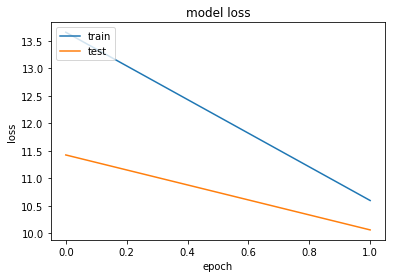

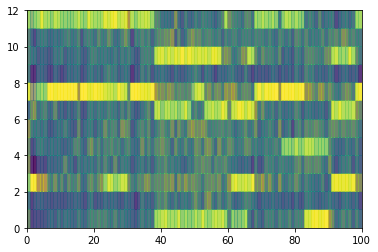

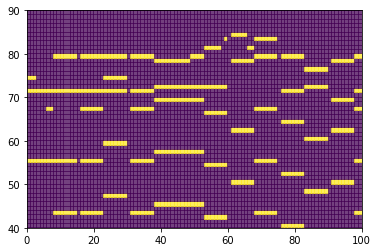

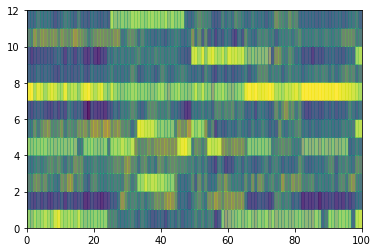

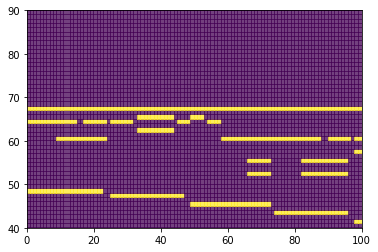

Train on 194629 samples, validate on 48658 samples

Epoch 1/2
194560/194629 [============================>.] - ETA: 0s - loss: 14.4537 - acc: 0.3365
Epoch 00001: saving model to Models/tst-best_only.hdf5
Epoch 00001: val_acc improved from -inf to 0.47754, saving model to Models/sgd_t9_lr_0Dot01-momentum_0Dot75-decay_0Dot0-01-0.48.hdf5
194629/194629 [==============================] - 30s 154us/step - loss: 14.4533 - acc: 0.3366 - val_loss: 14.1552 - val_acc: 0.4775

Epoch 2/2
194560/194629 [============================>.] - ETA: 0s - loss: 13.4516 - acc: 0.3238
Epoch 00002: saving model to Models/tst-best_only.hdf5
Epoch 00002: val_acc did not improve
194629/194629 [==============================] - 21s 107us/step - loss: 13.4513 - acc: 0.3238 - val_loss: 13.5697 - val_acc: 0.2967


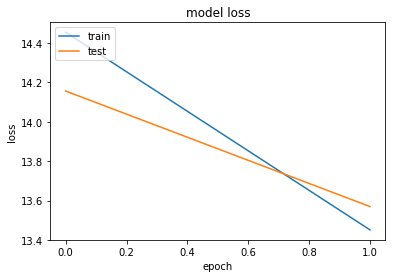

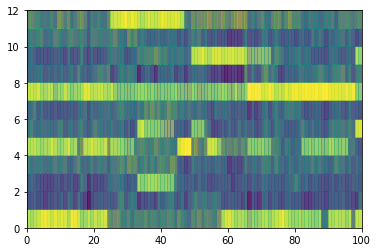

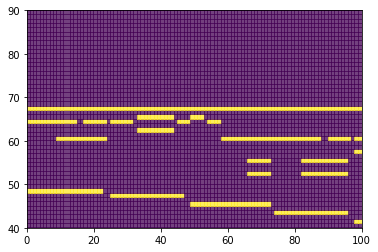

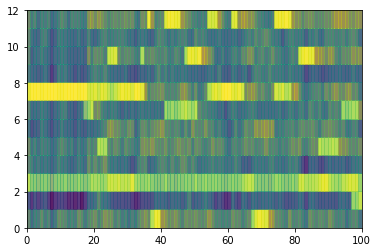

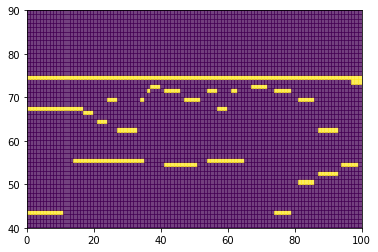

Train on 318635 samples, validate on 79659 samples

Epoch 1/2
 87040/318635 [=======>......................] - ETA: 45s - loss: 12.4478 - acc: 0.2704

KeyboardInterrupt: 

In [43]:
# np.random.seed(0)
# agent,r = pretrain()
# LOSS = 'binary_crossentropy'
# LOSS = 'kl_divergence'
LOSS = abs_KL_div


DIRs = ['sample/MIDI/',
        'sample/MIDI/midiworld/',
        'sample/MIDI/jsbach/']
for DIR in DIRs:
    data = load_data(DIR)
    Xs,Ys= make_buffer(data[1:])
    Ys = mroll2chroma(Ys,norm = 1)
#     Ys = mroll2chroma(Ys,norm = 0)

    compare(log = 1, mode = 'test',chroma = 1)
    compare(log = 1, mode = 'test',chroma = 0)
    plt.show()

    for i in range(1):
        agent,r = pretrain(agent,batchsize=-1,nepc = 2)
    compare(log = 1, mode = 'test',chroma = 1)
    compare(log = 1, mode = 'test',chroma = 0)
    plt.show()

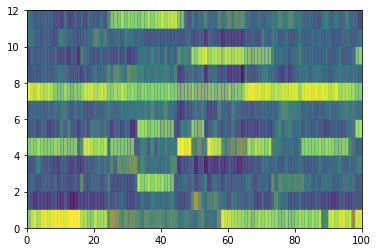

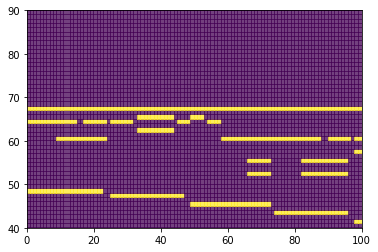

Train on 8000 samples, validate on 2000 samples

Epoch 1/2
7680/8000 [===========================>..] - ETA: 0s - loss: 14.1447 - acc: 0.3471
Epoch 00001: saving model to Models/tst-best_only.hdf5
Epoch 00001: val_acc improved from -inf to 0.32100, saving model to Models/sgd_t9_lr_0Dot01-momentum_0Dot75-decay_0Dot0-01-0.32.hdf5
8000/8000 [==============================] - 9s 1ms/step - loss: 14.1415 - acc: 0.3461 - val_loss: 14.0770 - val_acc: 0.3210

Epoch 2/2
7680/8000 [===========================>..] - ETA: 0s - loss: 13.7715 - acc: 0.3422
Epoch 00002: saving model to Models/tst-best_only.hdf5
Epoch 00002: val_acc improved from 0.32100 to 0.36750, saving model to Models/sgd_t9_lr_0Dot01-momentum_0Dot75-decay_0Dot0-02-0.37.hdf5
8000/8000 [==============================] - 1s 139us/step - loss: 13.7754 - acc: 0.3418 - val_loss: 13.8060 - val_acc: 0.3675


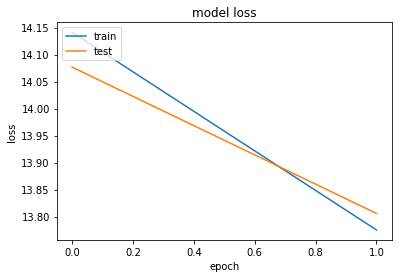

In [39]:
#         'sample/MIDI/midiworld/',

DIRs = [
#     'sample/MIDI/',
        'sample/MIDI/midiworld/',
#         'sample/MIDI/jsbach/'
]
for DIR in DIRs:
    data = load_data(DIR)
    Xs,Ys= make_buffer(data[1:])
    Ys = mroll2chroma(Ys,norm = 1)
#     Ys = mroll2chroma(Ys,norm = 0)

    compare(log = 1, mode = 'test',chroma = 1)
    compare(log = 1, mode = 'test',chroma = 0)
    plt.show()

    for i in range(1):
        _,r = pretrain(agent,batchsize=10000,nepc = 2)
#     compare(log = 1, mode = 'test',chroma = 1)
#     compare(log = 1, mode = 'test',chroma = 0)
#     plt.show()

In [ ]:
Epoch 2/2
322048/322357 [============================>.] - ETA: 0s - loss: 8.7223 - acc: 0.2744
Epoch 00001: saving model to Models/tst-best_only.hdf5
Epoch 00001: val_acc improved from 0.26189 to 0.27683, saving model to Models/sgd_t9_lr_0Dot01-momentum_0Dot75-decay_0Dot0-01-0.28.hdf5
322357/322357 [==============================] - 61s - loss: 8.7223 - acc: 0.2744 - val_loss: 8.6959 - val_acc: 0.2768


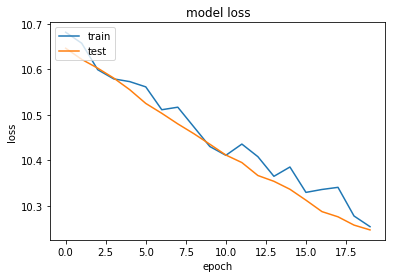

In [25]:
plot_model_loss(r)

In [501]:
# ali = 'test'
# agent = PGAgent(16000/20, 128,model = make_model())

# data = load_data()
# Xs,Ys = make_buffer(data)
bsize = 100

for i in range(10):
    idx = np.random.choice(len(Xs),bsize * 500,replace=0)
    subXs = Xs[idx]
    subYs = Ys[idx]

    opt_par = {'lr': 0.005, 'momentum': 0.75,'decay':0.000}
    opt = keras.optimizers.sgd(**opt_par)
    # agent.name = "sgd_t1_%s"% flatten_param(opt_par)
    try:
    #     agent.load()
        pass
    except Exception as e:
        print e
    # opt_par = {}
    # opt = keras.optimizers.Adam(**opt_par)
    # opt_par_flat = '-'.join(['_'.join(str(y) for y in x) for x in opt_par.items()]).replace('.','Dot')
    # agent.name = "adam_%s"%opt_par_flat

    agent.model.compile(loss=LOSS, optimizer=opt
                         ,metrics=['accuracy'])

    nepc = 40// int(bsize**0.5)
    r = agent.model.fit(subXs, subYs, epochs= IniEPOCH + nepc, initial_epoch=IniEPOCH, batch_size=bsize, validation_split=0.2,shuffle = 1, verbose = 2,
                         callbacks=default_callbacks(agent))
    IniEPOCH += nepc


Train on 40000 samples, validate on 10000 samples

Epoch 11/14

Epoch 00010: saving model to Models/tst-best_only.hdf5
Epoch 00010: val_acc improved from -inf to 0.16580, saving model to Models/sgd_t4_lr_0Dot01-momentum_0Dot75-decay_0Dot0-10-0.17.hdf5
14s - loss: 12.4125 - acc: 0.1412 - val_loss: 12.1217 - val_acc: 0.1658

Epoch 12/14

Epoch 00011: saving model to Models/tst-best_only.hdf5
Epoch 00011: val_acc improved from 0.16580 to 0.17780, saving model to Models/sgd_t4_lr_0Dot01-momentum_0Dot75-decay_0Dot0-11-0.18.hdf5
3s - loss: 11.7910 - acc: 0.1669 - val_loss: 11.8205 - val_acc: 0.1778

Epoch 13/14

Epoch 00012: saving model to Models/tst-best_only.hdf5
Epoch 00012: val_acc improved from 0.17780 to 0.18530, saving model to Models/sgd_t4_lr_0Dot01-momentum_0Dot75-decay_0Dot0-12-0.19.hdf5
3s - loss: 11.3431 - acc: 0.1882 - val_loss: 11.5709 - val_acc: 0.1853

Epoch 14/14

Epoch 00013: saving model to Models/tst-best_only.hdf5
Epoch 00013: val_acc improved from 0.18530 to 0.19420, 

KeyboardInterrupt: 